In [10]:
print("Hello Parth")

Hello Parth


## 1. Data Collection

### Obtain the data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Database Setup

In [5]:
import sqlite3

In [6]:
conn = sqlite3.connect("imdb_reviews.db")
cursor = conn.cursor()

In [7]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS imdb_reviews (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    review_text TEXT,
    sentiment TEXT
)
""")
print("Table created successfully!")

Table created successfully!


In [8]:
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO imdb_reviews (review_text, sentiment)
        VALUES (?, ?)
    """, (row["review"], row["sentiment"]))


conn.commit()
print(f"Inserted {len(df)} rows into the database")
conn.close()

Inserted 50000 rows into the database


## 2. Data Cleaning & Exploration

### Data Cleaning

In [5]:
import re

In [6]:
# Remove duplicate
df = df.drop_duplicates(subset="review", keep="first")
print(f"After removing duplicates, {len(df)} reviews remain")

After removing duplicates, 49582 reviews remain


In [7]:
# Handle missing value
df = df.dropna(subset=["review", "sentiment"])
print(f"After dropping missing values, {len(df)} reviews remain")

After dropping missing values, 49582 reviews remain


In [8]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # remove whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_review"] = df["review"].apply(clean_text)

In [9]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [20]:
conn = sqlite3.connect("imdb_reviews.db")
cursor = conn.cursor()

for _, row in df.iterrows():
    cursor.execute("""
        UPDATE imdb_reviews
        SET review_text = ?, sentiment = ?
        WHERE id = ?
    """, (row["cleaned_review"], row["sentiment"], row.name + 1))

conn.commit()
print("Database updated")
conn.close()

Database updated


### Exploratory Data Analysis (EDA)

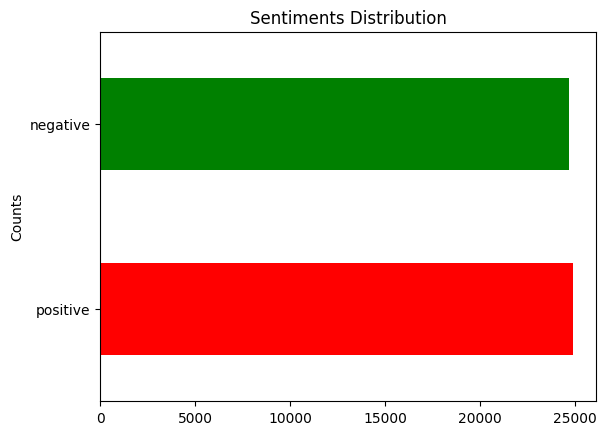

In [10]:
# Number of reviews per sentiment (distribution)
df["sentiment"].value_counts().plot(kind="barh", color=["red", "green"])
plt.title("Sentiments Distribution")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.show()

In [11]:
df["review_length"] = df["cleaned_review"].apply(len)

In [12]:
avg_len = df.groupby("sentiment")["review_length"].mean()
print("\nAverage Review Length by Sentiment:\n", avg_len)


Average Review Length by Sentiment:
 sentiment
negative    1227.546603
positive    1261.941890
Name: review_length, dtype: float64


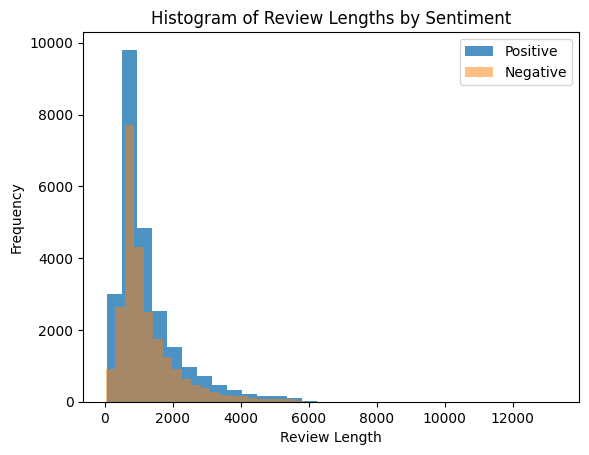

In [13]:
df[df["sentiment"] == "positive"]["review_length"].hist(bins=30, alpha=0.8, label="Positive")
df[df["sentiment"] == "negative"]["review_length"].hist(bins=30, alpha=0.5, label="Negative")
plt.title("Histogram of Review Lengths by Sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(False)
plt.show()

In [14]:
from wordcloud import WordCloud # type: ignore

In [15]:
all_text = " ".join(df["cleaned_review"])

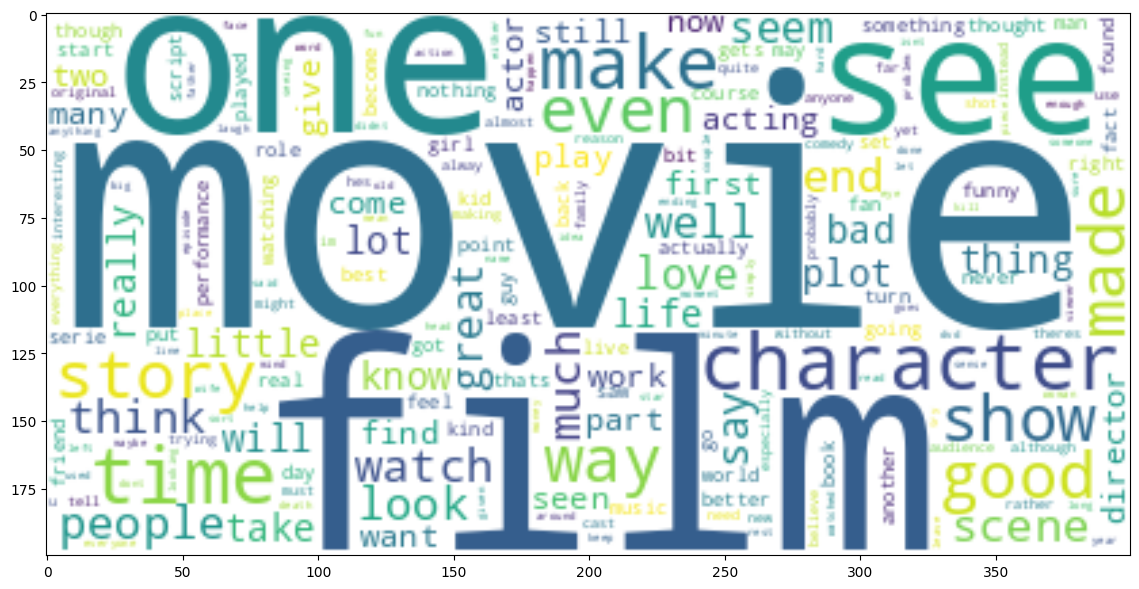

In [16]:
plt.figure(figsize=(12, 6))

all_text_wcloud = WordCloud(background_color="white").generate(all_text)
plt.imshow(all_text_wcloud, interpolation="bilinear")

plt.tight_layout()
plt.show()

## 3. Model Training

In [18]:
df["sentiment_label"] = df["sentiment"].apply(lambda x: 0 if x == "positive" else 1)

In [20]:
X = df["cleaned_review"]
y = df["sentiment_label"]

In [ ]:
from sklearn.model_selection import train_test_split # type: ignore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

tfidf_vectorizer = TfidfVectorizer()
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

In [36]:
from sklearn.naive_bayes import MultinomialNB # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.metrics import accuracy_score, classification_report # type: ignore

models = {
    "Multinomial NB": MultinomialNB(),
    "Logistic Regression": LogisticRegression()
}

model_performance = {}

for name, model in models.items():
    print(f"Model : {name}")
    
    model.fit(X_train_tf, y_train)
    
    y_pred_train = model.predict(X_train_tf)
    
    y_pred_test = model.predict(X_test_tf)
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    model_performance[name] = test_accuracy
    
    print(f"Training Accuracy : {accuracy_score(y_train, y_pred_train)}")
    print(f"Testing Accuracy : {accuracy_score(y_test, y_pred_test)}")
    
    print(f"Classification Report of {name} : \n")
    print(classification_report(y_test, y_pred_test, target_names=["Positive", "Negative"]))
    
    print("="*70)

Model : Multinomial NB
Training Accuracy : 0.9147863355603176
Testing Accuracy : 0.8639709589593627
Classification Report of Multinomial NB : 

              precision    recall  f1-score   support

    Positive       0.88      0.85      0.86      4978
    Negative       0.85      0.88      0.87      4939

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

Model : Logistic Regression
Training Accuracy : 0.931602168158326
Testing Accuracy : 0.8931128365433094
Classification Report of Logistic Regression : 

              precision    recall  f1-score   support

    Positive       0.88      0.91      0.90      4978
    Negative       0.91      0.88      0.89      4939

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [37]:
model_performance

{'Multinomial NB': 0.8639709589593627,
 'Logistic Regression': 0.8931128365433094}

In [41]:
# Find the best model
best_model_name = max(model_performance, key=model_performance.get)
best_model = models[best_model_name]
print(f"Best Model = {best_model_name}\nAccuracy = {model_performance[best_model_name]: .4f}")

Best Model = Logistic Regression
Accuracy =  0.8931


In [43]:
import pickle

# Save Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer:
    pickle.dump(tfidf_vectorizer, vectorizer)
print("Save Vectorizer")

# Save Best Model
with open(f"model.pkl", "wb") as model:
    pickle.dump(best_model, model)
print("Save Best Model")

Save Vectorizer
Save Best Model
